#The Microsoft malware detection project has been divided into 3 notebooks : File and Feature extraction part is done in GCP and training with extracted features is done in colab, due to memory constraints.

(1) 'Byte_feat' notebook contains the extraction of the whole data files and feature extraction of byte files

(2) 'ASM_feat' notebook contains the feature extraction of asm files


(3) 'Modelling' notebook contains all the training of the extracted features.


Mainly, references and code snippets has been taken/inspired from these mentioned sources for the overview and understanding purposes.


(1) https://github.com/dchad/malware-detection

(2) https://github.com/saugatapaul1010/Microsoft-Malware-Detection-using-Machine-Learning/blob/master/Microsoft%20Malware%20Detection%20Latest%20Version.ipynb

(3) https://towardsdatascience.com/malware-classification-using-machine-learning-7c648fb1da79

(4) https://www.youtube.com/watch?v=VLQTRlLGz5Y#t=13m11s

(5) https://www.kaggle.com/c/microsoft-malware-prediction

(6) https://colab.research.google.com/drive/13foR1XAg2UyLbUgmMGT2GuIk_MX1FSKy#scrollTo=H7uj0MitbK2l                 (Applied AI microsoft assignment)

In [ ]:
#importing libraries
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2

In [ ]:
#importing train labels
Y=pd.read_csv('/content/drive/My Drive/assignment questions/MicrosoftMalware/trainLabels.csv')
Y.columns=['ID','Class']
print('shape',Y.shape)
Y.head()

shape (10868, 2)


,ID,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1


In [ ]:
#creating a dataframe for byte features from .csv file computed in the refernce assignment
result_with_size=pd.read_csv('/content/drive/My Drive/assignment questions/MicrosoftMalware/result_with_size.csv',index_col=False)
result_with_size=result_with_size.drop('Unnamed: 0',axis=1)
print('shape : ',result_with_size.shape)
result_with_size.head()

shape :  (10868, 260)


,ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,...,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,3211,3546,4038,4096,3218,3032,3269,2740,3459,2767,3354,4049,3184,3495,3139,2810,3444,3130,3786,3682,2665,3100,2990,3175,2826,4295,8565,4002,3105,...,3438,2773,2778,3467,2753,3097,3504,2764,2746,2913,3179,3088,2678,4710,3034,3127,3409,3571,2669,3523,3476,3685,3138,2727,2808,3209,3233,3271,2804,3687,3101,3211,3097,2758,3099,2759,5753,1824,4.234863,9
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,340,6649,8660,447,218,6869,8869,228,352581,187,12034,353,349,154,6735,307,278,209,688,266,321,213,12372,309,196,296,8979,301,288,...,547,617,452,504,449,503,400,401,797,497,353,368,312,7506,6878,394,6910,8206,223,385,442,6813,484,424,352,519,265,290,451,6536,439,281,302,7639,518,17001,54902,8588,5.538818,2
2,01jsnpXSAlgw6aPeDxrU,93506,9542,2568,2438,8925,9330,9007,2342,9107,2457,2655,2669,9113,2584,2788,2487,2782,2611,2301,2706,2968,2808,2408,2416,2677,2327,2788,2972,2659,2433,2267,2893,2575,2482,2801,2565,2524,2327,2546,...,2572,2565,2675,2473,2642,2456,2728,2369,2552,2746,2511,2246,2454,22304,2514,2804,2660,3042,2554,2520,2755,2619,2491,2537,2409,2456,2685,2598,2325,2358,2242,2885,2863,2471,2786,2680,49144,468,3.887939,9
3,01kcPWA9K2BOxQeS5Rju,21091,1213,726,817,1257,625,550,523,1078,473,516,445,808,432,403,705,1067,407,389,423,644,520,413,412,520,404,360,369,478,377,342,363,926,350,371,366,950,566,350,...,828,522,357,543,454,480,355,405,398,566,404,358,366,2899,718,412,943,857,406,389,340,886,519,472,438,603,348,446,478,873,485,462,516,1133,471,761,7998,13940,0.574219,1
4,01SuzwMJEIXsK7A8dQbl,19764,710,302,433,559,410,262,249,422,223,237,226,406,643,213,272,447,242,240,236,437,693,240,217,348,286,240,207,350,229,214,230,418,441,334,282,398,486,252,...,245,246,243,205,221,258,768,274,223,261,250,231,225,546,543,310,255,379,211,273,223,374,527,212,229,492,345,483,847,947,350,209,239,653,221,242,2199,9008,0.370850,8


In [ ]:
#creating a dataframe for asm features from .csv file computed in the given assignment
asm_feat=pd.read_csv('/content/drive/My Drive/assignment questions/MicrosoftMalware/asmoutputfile.csv',index_col=False)
print('Shape : ',asm_feat.shape)
asm_feat.head()


Shape :  (10868, 52)


,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,.tls:,.reloc:,.BSS:,.CODE,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,dec,add,imul,xchg,or,shr,cmp,call,shl,ror,rol,jnb,jz,rtn,lea,movzx,.dll,std::,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,0,3,0,0,12,89,0,81,19,18,16,0,5,6,3,11,0,0,6,0,15,53,1,0,0,5,13,0,36,1,23,35,137,18,66,15,43,83,0,17,48,29
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,0,3,0,0,4,88,0,79,26,19,9,0,8,4,4,6,1,0,0,0,19,29,0,0,0,1,7,0,20,1,12,64,130,18,29,48,82,12,0,14,0,20
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,0,3,0,0,5,73,0,53,18,9,7,0,5,2,1,2,1,0,4,0,14,21,2,0,0,0,10,0,4,1,36,13,84,13,42,10,67,14,0,11,0,9
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,0,3,0,0,0,13,0,11,6,8,3,0,3,1,0,3,0,0,1,0,0,4,2,0,0,0,1,0,2,0,3,8,25,6,8,14,7,2,0,8,0,6
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,0,3,0,0,6,19,0,31,5,3,2,0,2,0,0,3,2,0,0,0,10,8,1,1,0,0,3,0,4,1,7,11,18,12,9,18,29,5,0,11,0,11


#Feature Set-1 (byte unigrams + byte file size + asm unigrams + byte bigrams)

In [ ]:
# I have computed the bigram features on GCP and then I have created a .csv file which I am using below.
#creating a dataframe for byte-bigram features from .csv file

byte_bigram_df_new=pd.read_csv('/content/drive/My Drive/red_byte_bigram_df_new.csv',index_col=False)
byte_bigram_df_new=byte_bigram_df_new.drop('Unnamed: 0',axis=1)

print(byte_bigram_df_new.shape)
byte_bigram_df_new.head(3)

(10868, 1323)


,ID,00 00,00 01,00 02,00 03,00 04,00 05,00 06,00 07,00 08,00 0b,00 0c,00 0d,00 0e,00 0f,00 10,00 11,00 12,00 13,00 14,00 15,00 16,00 17,00 18,00 19,00 1a,00 1b,00 1c,00 1d,00 1e,00 1f,00 20,00 21,00 22,00 23,00 24,00 25,00 26,00 27,00 28,...,f8 f8,f9 00,f9 f9,fa 00,fa 06,fa fa,fb 00,fc 00,fc 02,fc 04,fc 06,fc 8b,fc f7,fc fc,fc fd,fd 00,fd 8b,fd f7,fd fc,fd fd,fd ff,fe 00,fe 02,fe 04,fe 06,fe fe,fe ff,ff 00,ff 02,ff 04,ff 12,ff 15,ff 55,ff 59,ff 75,ff 83,ff 8b,ff ff,?? ??,Class
0,2BWnr5UAQ43bEg8tKJ0y,18681,569,86,77,156,15,23,5,30,25,56,21,8,84,343,26,232,27,27,25,146,8,47,7,15,25,28,19,14,14,515,6277,86,64,24,10,14,0,158,...,0,20,0,6,0,0,8,67,2,1,0,39,10,2,8,9,9,0,0,1,93,12,0,4,0,41,589,2639,13,19,18,174,311,283,505,290,374,7224,9031,2
1,F8bN6Gx0wTRZWsHI3XLO,24885,734,2698,99,276,66,65,70,91,47,101,14,5,113,456,8,292,3,59,4,162,7,108,7,5,1,8,3,1,3,596,6,7,16,89,3,2,2,155,...,3847,14,1,6,0,1,3,119,2550,61,68,75,10,5269,7,12,10,0,0,6,99,94,2328,61,78,4810,210,1770,2201,60,63,136,306,421,930,662,416,12136,12611,2
2,Ajy4saxIMJfzOi3CcH0S,11071,209,52,50,100,59,39,21,67,23,65,35,15,55,915,26,20,12,40,30,11,8,27,9,13,6,41,16,14,15,167,1,13,5,41,37,10,12,46,...,8,18,1,14,7,2,23,53,2,14,3,74,2,15,2,12,13,0,4,0,66,35,6,4,3,2,149,710,34,69,13,134,104,79,58,66,505,1549,7418,1


In [ ]:
#https://github.com/dchad/malware-detection
#selecting the top 25 percent of the features with the highest variance using chi-square test

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2

X_t=(byte_bigram_df_new.iloc[:,1:1322]) #selecting dataframe without class and ID
y_t=y = byte_bigram_df_new.iloc[:,-1] #selecting labels

fsp = SelectPercentile(chi2, 25) #top 25 percentile features with highest chi-square test scores
X_new_20 = fsp.fit_transform(X_t,y_t)
print(X_new_20.shape)

selected_names = fsp.get_support(indices=True) #getting the indices of the features selected
selected_names = selected_names + 1

data_trimmed = byte_bigram_df_new.iloc[:,selected_names]
data_fnames = pd.DataFrame(byte_bigram_df_new['ID'])
red_byte_bigram_df_new = data_fnames.join(data_trimmed)
red_byte_bigram_df_new.head() #returning the new dataframe

(10868, 330)


,ID,00 00,00 01,00 02,00 04,00 06,00 08,00 0f,00 10,00 12,00 16,00 1c,00 20,00 30,00 33,00 4a,00 56,00 59,00 68,00 6a,00 74,00 7d,00 83,00 85,00 8b,00 8d,00 a2,00 ad,00 b7,00 bb,00 be,00 c0,00 cf,00 e8,00 eb,00 fb,00 fe,00 ff,01 00,01 01,...,f0 f0,f0 f1,f0 f2,f1 01,f1 f0,f1 f2,f2 01,f2 f0,f2 f1,f2 f2,f7 e0,f7 e1,f7 e2,f7 e3,f7 e6,f7 e7,f7 e8,f7 e9,f7 ea,f7 eb,f7 ee,f7 ef,f8 f8,fa 06,fa fa,fb 00,fc f7,fc fc,fd 8b,fd f7,fd fd,fe 00,fe fe,fe ff,ff 00,ff 15,ff 75,ff 8b,ff ff,?? ??
0,2BWnr5UAQ43bEg8tKJ0y,18681,569,86,156,23,30,84,343,232,146,28,515,34,107,31,57,122,151,70,138,5,216,66,379,106,6,3,1,14,13,53,8,167,80,7,65,1968,814,115,...,2,7,0,0,0,4,0,0,0,0,0,3,0,0,4,0,0,0,0,1,0,0,0,0,0,8,10,2,9,0,1,12,41,589,2639,174,505,374,7224,9031
1,F8bN6Gx0wTRZWsHI3XLO,24885,734,2698,276,65,91,113,456,292,162,8,596,9,130,18,91,191,281,108,229,63,233,139,306,130,3,8,2,17,27,117,13,158,163,8,130,2807,853,5550,...,4378,5,0,0,2,4,1,0,1,2,0,8,0,1,2,2,1,0,1,1,1,0,3847,0,1,3,10,5269,10,0,6,94,4810,210,1770,136,930,416,12136,12611
2,Ajy4saxIMJfzOi3CcH0S,11071,209,52,100,39,67,55,915,20,11,41,167,70,68,9,58,72,146,51,221,19,107,77,496,119,6,5,11,7,10,146,9,287,79,18,37,709,395,47,...,8,1,2,1,2,2,2,1,3,1,3,2,0,0,2,0,2,4,0,5,1,1,8,7,2,23,2,15,13,0,0,35,2,149,710,134,58,505,1549,7418
3,5su2fIARtLqUzSdQgDB9,104880,724,569,721,602,774,667,534,494,468,438,519,537,586,661,614,684,559,698,888,521,730,843,974,944,507,433,447,466,444,797,412,1001,519,466,553,1829,749,2237,...,380,7,7,21,9,6,18,7,3,7,11,9,6,7,18,10,53,8,5,17,7,3,1155,17,267,448,17,916,39,15,388,525,978,441,1812,283,200,386,11406,541
4,g9A5fmc63Sth41uoBLEz,30768,671,440,208,125,127,276,551,370,163,118,592,289,356,90,109,252,205,216,259,68,517,191,686,271,74,55,40,46,58,155,64,403,233,45,263,1646,1064,401,...,23,5,0,53,0,4,42,0,0,2,0,4,0,2,2,1,0,0,0,6,0,4,3,0,0,62,3,3,77,0,4,79,20,728,984,192,989,800,5239,10343


In [ ]:
#merging all the above features into a single dataframe feature_set_1
feature_set_1 = result_with_size.merge(red_byte_bigram_df_new, on='ID',how='left')
feature_set_1 =feature_set_1.merge(asm_feat, on='ID',how='left')
feature_set_1.head(2)

,ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,...,.BSS:,.CODE,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,dec,add,imul,xchg,or,shr,cmp,call,shl,ror,rol,jnb,jz,rtn,lea,movzx,.dll,std::,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,3211,3546,4038,4096,3218,3032,3269,2740,3459,2767,3354,4049,3184,3495,3139,2810,3444,3130,3786,3682,2665,3100,2990,3175,2826,4295,8565,4002,3105,...,0,0,730,5295,0,3208,542,418,290,0,648,3,5,622,82,0,197,2,672,1533,158,0,0,0,557,0,308,0,1490,1891,4371,808,2290,1281,587,701,0,15,14,456
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,340,6649,8660,447,218,6869,8869,228,352581,187,12034,353,349,154,6735,307,278,209,688,266,321,213,12372,309,196,296,8979,301,288,...,0,0,47,2190,0,569,186,106,252,9,216,22,21,323,30,0,93,14,218,333,23,0,0,23,54,0,195,43,724,496,1446,260,1090,391,905,420,0,24,22,227


In [ ]:
#labels for the data set
y=feature_set_1['Class']
#dropping the class and ID columns too
feature_set_1=feature_set_1.drop('Class',axis=1)
feature_set_1=feature_set_1.drop('ID',axis=1)
print( ' Shape of feature  set 1 : ',feature_set_1.shape)
feature_set_1.head(2)

 Shape of feature  set 1 :  (10868, 639)


,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,...,.BSS:,.CODE,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,dec,add,imul,xchg,or,shr,cmp,call,shl,ror,rol,jnb,jz,rtn,lea,movzx,.dll,std::,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,3211,3546,4038,4096,3218,3032,3269,2740,3459,2767,3354,4049,3184,3495,3139,2810,3444,3130,3786,3682,2665,3100,2990,3175,2826,4295,8565,4002,3105,2983,...,0,0,730,5295,0,3208,542,418,290,0,648,3,5,622,82,0,197,2,672,1533,158,0,0,0,557,0,308,0,1490,1891,4371,808,2290,1281,587,701,0,15,14,456
1,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,340,6649,8660,447,218,6869,8869,228,352581,187,12034,353,349,154,6735,307,278,209,688,266,321,213,12372,309,196,296,8979,301,288,282,...,0,0,47,2190,0,569,186,106,252,9,216,22,21,323,30,0,93,14,218,333,23,0,0,23,54,0,195,43,724,496,1446,260,1090,391,905,420,0,24,22,227


In [ ]:
# https://stackoverflow.com/a/29651514
#for normalizing all the features
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
#normalizing all the features and filling the NaN values with 0
result_1 = normalize(feature_set_1)
result_1=result_1.fillna(0)
result_1.head(2)

,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,...,.BSS:,.CODE,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,dec,add,imul,xchg,or,shr,cmp,call,shl,ror,rol,jnb,jz,rtn,lea,movzx,.dll,std::,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,0.262806,0.005498,0.001567,0.002067,0.002048,0.001835,0.002058,0.002946,0.002638,0.003531,0.006862,0.001947,0.006293,0.005456,0.004779,0.005338,0.001887,0.005353,0.004134,0.002097,0.003493,0.008066,0.003777,0.004430,0.002300,0.002007,0.003331,0.002480,0.002947,0.005665,0.005371,0.003437,0.005760,0.002766,0.002770,0.004628,0.006888,0.003829,0.005878,0.003316,...,0.0,0.0,0.036750,0.035512,0.0,0.033192,0.014918,0.009862,0.019237,0.000000,0.048884,0.000096,0.000912,0.025013,0.001977,0.0,0.014360,0.000198,0.036081,0.039435,0.010084,0.0,0.0,0.000000,0.026414,0.0,0.012401,0.000000,0.015763,0.024298,0.032784,0.015418,0.025875,0.025744,0.00491,0.00893,0.0,0.027174,0.000428,0.049896
1,0.017358,0.011737,0.004033,0.003876,0.005303,0.003873,0.004747,0.006984,0.008267,0.000394,0.000727,0.003650,0.013496,0.000595,0.000324,0.012093,0.005120,0.000445,0.421371,0.000142,0.012532,0.000703,0.000414,0.000195,0.004935,0.000219,0.000269,0.000166,0.000535,0.000409,0.000647,0.000236,0.023833,0.000269,0.000192,0.000319,0.007220,0.000288,0.000545,0.000313,...,0.0,0.0,0.002366,0.014688,0.0,0.005887,0.005119,0.002501,0.016716,0.000121,0.016295,0.000707,0.003830,0.012989,0.000723,0.0,0.006779,0.001384,0.011705,0.008566,0.001468,0.0,0.0,0.003433,0.002561,0.0,0.007851,0.006049,0.007659,0.006373,0.010846,0.004961,0.012316,0.007858,0.00757,0.00535,0.0,0.043478,0.000673,0.024839


In [ ]:
#reference: given microsoft assignment

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result_1, y,stratify=y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

#printing the no. of datapoints in each set
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

#printing the shape of each set
print('Shape of train data:', X_train.shape)
print('Shape of test data:', X_test.shape)
print('Shape of cross validation data:', X_cv.shape)

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739
Shape of train data: (6955, 639)
Shape of test data: (2174, 639)
Shape of cross validation data: (1739, 639)


In [ ]:
# code snippet : applied AI assignemnt notebook
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j

    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column

    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1

    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]]

    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))


log_loss for c =  10 is 0.043080117384204905
log_loss for c =  50 is 0.04064119826184856
log_loss for c =  100 is 0.03869203321051745
log_loss for c =  500 is 0.038448709602686426
log_loss for c =  1000 is 0.038319004168936466


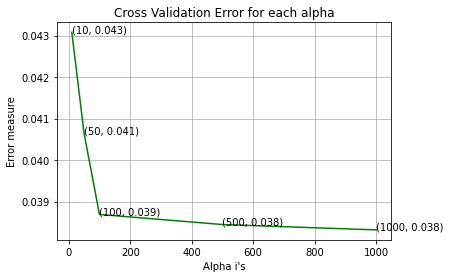

For values of best alpha =  1000 The train log loss is: 0.015543023932305685
For values of best alpha =  1000 The cross validation log loss is: 0.038319004168936466
For values of best alpha =  1000 The test log loss is: 0.04156528490606676
Number of misclassified points  0.9199632014719411
-------------------------------------------------- Confusion matrix --------------------------------------------------


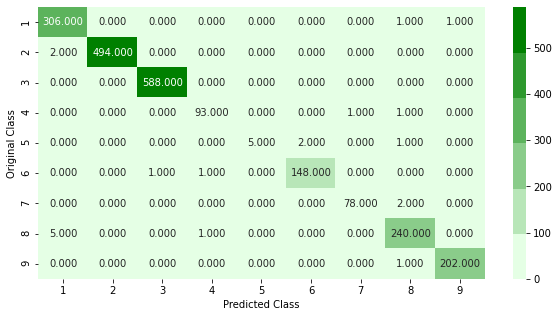

-------------------------------------------------- Precision matrix --------------------------------------------------


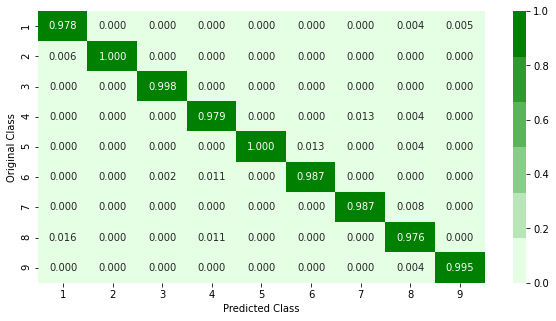

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


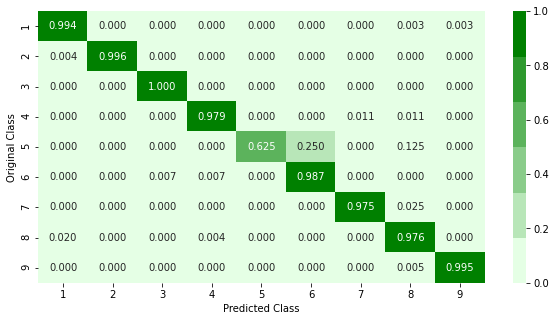

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# # code snippet : applied AI assignemnt notebook

alpha=[10,50,100,500,1000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))


log_loss for c =  10 is 0.08743595413499154
log_loss for c =  50 is 0.055843435495036564
log_loss for c =  100 is 0.04753853844766862
log_loss for c =  500 is 0.046132855118235165
log_loss for c =  1000 is 0.04616460956095543


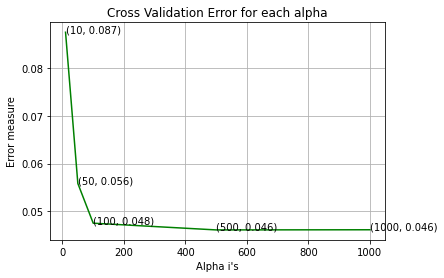

For values of best alpha =  500 The train log loss is: 0.011788360846744448
For values of best alpha =  500 The cross validation log loss is: 0.046132855118235165
For values of best alpha =  500 The test log loss is: 0.023488277813003108
Number of misclassified points  0.22999080036798528
-------------------------------------------------- Confusion matrix --------------------------------------------------


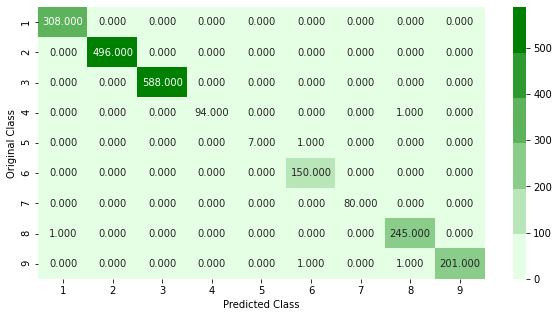

-------------------------------------------------- Precision matrix --------------------------------------------------


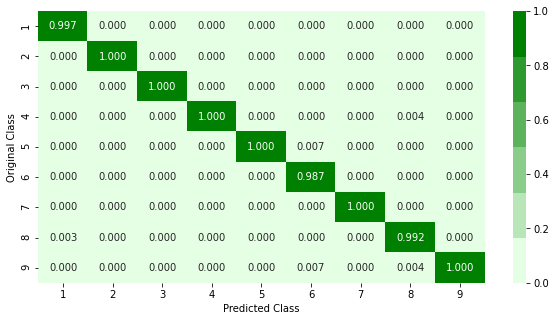

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


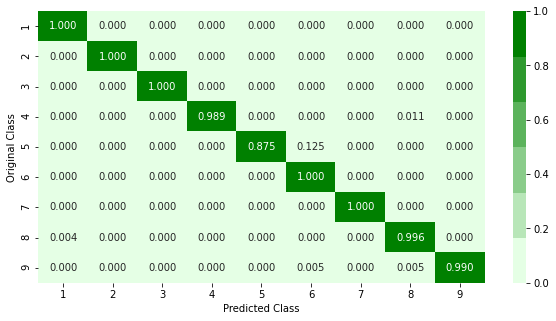

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data
# code snippet : applied AI assignemnt notebook

alpha=[10,50,100,500,1000]
cv_log_error_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,tree_method='gpu_hist')
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],tree_method='gpu_hist')
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

After adding bi-gram features we can see that, test log loss is reduce to : 0.023488277813003108

#Feature Set-2 (byte unigrams + byte file size + asm unigrams + top 800 asm image pixel intensities)

In [ ]:
#creating a dataframe for asm pixel intensity features from .csv file
asm_img_800=pd.read_csv('/content/drive/My Drive/assignment questions/MicrosoftMalware/asm_image_df.csv',index_col=False)
print(asm_img_800.shape)
asm_img_800.head(10)

(10868, 801)


,ID,Pixel0,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,Pixel10,Pixel11,Pixel12,Pixel13,Pixel14,Pixel15,Pixel16,Pixel17,Pixel18,Pixel19,Pixel20,Pixel21,Pixel22,Pixel23,Pixel24,Pixel25,Pixel26,Pixel27,Pixel28,Pixel29,Pixel30,Pixel31,Pixel32,Pixel33,Pixel34,Pixel35,Pixel36,Pixel37,Pixel38,...,Pixel760,Pixel761,Pixel762,Pixel763,Pixel764,Pixel765,Pixel766,Pixel767,Pixel768,Pixel769,Pixel770,Pixel771,Pixel772,Pixel773,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783,Pixel784,Pixel785,Pixel786,Pixel787,Pixel788,Pixel789,Pixel790,Pixel791,Pixel792,Pixel793,Pixel794,Pixel795,Pixel796,Pixel797,Pixel798,Pixel799
0,jExBgXmKlhA4URac86kQ,46,116,101,120,116,58,48,48,52,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,13,10,46,116,101,120,116,58,48,48,52,...,32,58,32,80,111,114,116,97,98,108,101,9,101,120,101,99,117,116,97,98,108,101,32,102,111,114,32,56,48,51,56,54,32,40,80,69,41,13,10,46
1,0RSW8EmilbznyYPIrgvD,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,109,109,120,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,9,9,46,109,111,100,101,108,32,102,108,97,116
2,2zsVAYPQrf3GFoD5JhC0,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
3,E3sij5MlNGadWfcSDvQw,46,116,101,120,116,58,48,48,52,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,13,10,46,116,101,120,116,58,48,48,52,...,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,32,70,111,114,109,97,116,9,32,32,32,32,32,58,32,80,111,114,116,97,98
4,bDfQnleI6rqp5Nw9GC3O,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,109,109,120,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,9,9,46,109,111,100,101,108,32,102,108,97,116
5,9joLAv30xuTSM4fqNbJZ,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,9,59,32,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
6,8cM57th1BVwar2szTENJ,46,116,101,120,116,58,48,48,52,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,13,10,46,116,101,120,116,58,48,48,52,...,32,58,32,80,111,114,116,97,98,108,101,9,101,120,101,99,117,116,97,98,108,101,32,102,111,114,32,56,48,51,56,54,32,40,80,69,41,13,10,46
7,2i5N9Ftj3xoySflKzbAC,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,9,9,46,109,109,120,13,10,72,69,65,68,69,82,58,48,48
8,lkqEXK4NrYSseRTt0Gb3,72,69,65,68,69,82,58,49,48,48,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,49,48,48,48,48,48,48,...,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
9,6IrZu0ynlqf4otPBA7HT,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61


In [ ]:
#merging all the above features into a single dataframe feature_set_1
feature_set_2 = result_with_size.merge(asm_img_800, on='ID',how='left')
feature_set_2 =feature_set_2.merge(asm_feat, on='ID',how='left')
feature_set_2.head(2)

,ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,...,.BSS:,.CODE,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,dec,add,imul,xchg,or,shr,cmp,call,shl,ror,rol,jnb,jz,rtn,lea,movzx,.dll,std::,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,3211,3546,4038,4096,3218,3032,3269,2740,3459,2767,3354,4049,3184,3495,3139,2810,3444,3130,3786,3682,2665,3100,2990,3175,2826,4295,8565,4002,3105,...,0,0,730,5295,0,3208,542,418,290,0,648,3,5,622,82,0,197,2,672,1533,158,0,0,0,557,0,308,0,1490,1891,4371,808,2290,1281,587,701,0,15,14,456
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,340,6649,8660,447,218,6869,8869,228,352581,187,12034,353,349,154,6735,307,278,209,688,266,321,213,12372,309,196,296,8979,301,288,...,0,0,47,2190,0,569,186,106,252,9,216,22,21,323,30,0,93,14,218,333,23,0,0,23,54,0,195,43,724,496,1446,260,1090,391,905,420,0,24,22,227


In [ ]:
#labels for the data set
y=feature_set_2['Class']
#dropping the class and ID columns too
feature_set_2=feature_set_2.drop('Class',axis=1)
feature_set_2=feature_set_2.drop('ID',axis=1)
print( ' Shape of feature  set 1 : ',feature_set_2.shape)
feature_set_2.head(2)

 Shape of feature  set 1 :  (10868, 1109)


,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,...,.BSS:,.CODE,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,dec,add,imul,xchg,or,shr,cmp,call,shl,ror,rol,jnb,jz,rtn,lea,movzx,.dll,std::,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,3211,3546,4038,4096,3218,3032,3269,2740,3459,2767,3354,4049,3184,3495,3139,2810,3444,3130,3786,3682,2665,3100,2990,3175,2826,4295,8565,4002,3105,2983,...,0,0,730,5295,0,3208,542,418,290,0,648,3,5,622,82,0,197,2,672,1533,158,0,0,0,557,0,308,0,1490,1891,4371,808,2290,1281,587,701,0,15,14,456
1,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,340,6649,8660,447,218,6869,8869,228,352581,187,12034,353,349,154,6735,307,278,209,688,266,321,213,12372,309,196,296,8979,301,288,282,...,0,0,47,2190,0,569,186,106,252,9,216,22,21,323,30,0,93,14,218,333,23,0,0,23,54,0,195,43,724,496,1446,260,1090,391,905,420,0,24,22,227


In [ ]:
# https://stackoverflow.com/a/29651514
#for normalizing all the features
# code snippet : applied AI assignemnt notebook

def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
#normalizing all the features and filling the NaN values with 0
result_2 = normalize(feature_set_2)
result_2=result_2.fillna(0)
result_2.head(2)

,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,...,.BSS:,.CODE,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,dec,add,imul,xchg,or,shr,cmp,call,shl,ror,rol,jnb,jz,rtn,lea,movzx,.dll,std::,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,0.262806,0.005498,0.001567,0.002067,0.002048,0.001835,0.002058,0.002946,0.002638,0.003531,0.006862,0.001947,0.006293,0.005456,0.004779,0.005338,0.001887,0.005353,0.004134,0.002097,0.003493,0.008066,0.003777,0.004430,0.002300,0.002007,0.003331,0.002480,0.002947,0.005665,0.005371,0.003437,0.005760,0.002766,0.002770,0.004628,0.006888,0.003829,0.005878,0.003316,...,0.0,0.0,0.036750,0.035512,0.0,0.033192,0.014918,0.009862,0.019237,0.000000,0.048884,0.000096,0.000912,0.025013,0.001977,0.0,0.014360,0.000198,0.036081,0.039435,0.010084,0.0,0.0,0.000000,0.026414,0.0,0.012401,0.000000,0.015763,0.024298,0.032784,0.015418,0.025875,0.025744,0.00491,0.00893,0.0,0.027174,0.000428,0.049896
1,0.017358,0.011737,0.004033,0.003876,0.005303,0.003873,0.004747,0.006984,0.008267,0.000394,0.000727,0.003650,0.013496,0.000595,0.000324,0.012093,0.005120,0.000445,0.421371,0.000142,0.012532,0.000703,0.000414,0.000195,0.004935,0.000219,0.000269,0.000166,0.000535,0.000409,0.000647,0.000236,0.023833,0.000269,0.000192,0.000319,0.007220,0.000288,0.000545,0.000313,...,0.0,0.0,0.002366,0.014688,0.0,0.005887,0.005119,0.002501,0.016716,0.000121,0.016295,0.000707,0.003830,0.012989,0.000723,0.0,0.006779,0.001384,0.011705,0.008566,0.001468,0.0,0.0,0.003433,0.002561,0.0,0.007851,0.006049,0.007659,0.006373,0.010846,0.004961,0.012316,0.007858,0.00757,0.00535,0.0,0.043478,0.000673,0.024839


In [ ]:
#reference: given microsoft assignment

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result_2, y,stratify=y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

#printing the no. of datapoints in each set
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

#printing the shape of each set
print('Shape of train data:', X_train.shape)
print('Shape of test data:', X_test.shape)
print('Shape of cross validation data:', X_cv.shape)

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739
Shape of train data: (6955, 1109)
Shape of test data: (2174, 1109)
Shape of cross validation data: (1739, 1109)



log_loss for c =  10 is 0.03495363460781138
log_loss for c =  50 is 0.03262627432021277
log_loss for c =  100 is 0.03259869633293584
log_loss for c =  500 is 0.0327404865035525
log_loss for c =  1000 is 0.03270070130035687


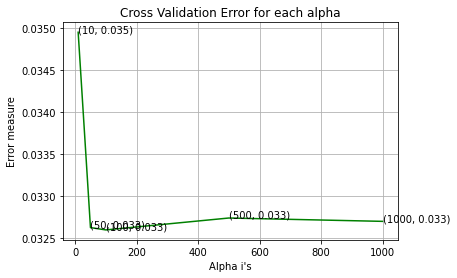

For values of best alpha =  100 The train log loss is: 0.011378746456730504
For values of best alpha =  100 The cross validation log loss is: 0.03259869633293584
For values of best alpha =  100 The test log loss is: 0.0269160398165631
Number of misclassified points  0.45998160073597055
-------------------------------------------------- Confusion matrix --------------------------------------------------


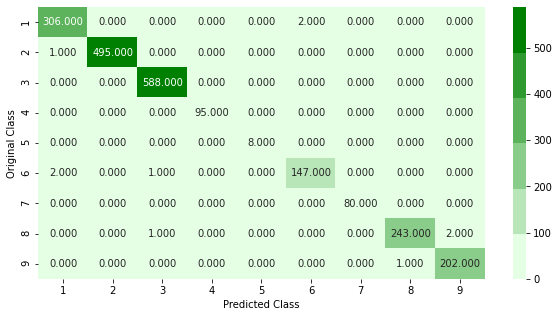

-------------------------------------------------- Precision matrix --------------------------------------------------


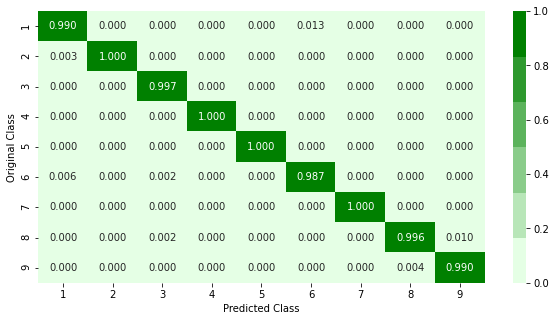

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


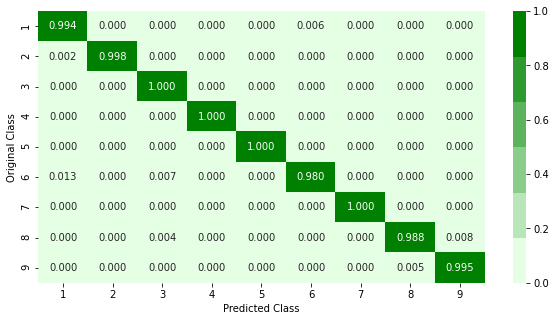

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# code snippet : applied AI assignemnt notebook

alpha=[10,50,100,500,1000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))


log_loss for c =  10 is 0.062386861561666625
log_loss for c =  50 is 0.04067237687879895
log_loss for c =  100 is 0.03905897815202799
log_loss for c =  500 is 0.03984074312474715
log_loss for c =  1000 is 0.03981647347946212


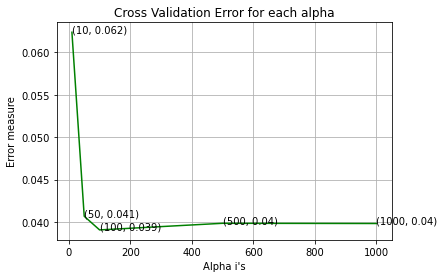

For values of best alpha =  100 The train log loss is: 0.009926697265145345
For values of best alpha =  100 The cross validation log loss is: 0.03905897815202799
For values of best alpha =  100 The test log loss is: 0.02188269949973768
Number of misclassified points  0.41398344066237347
-------------------------------------------------- Confusion matrix --------------------------------------------------


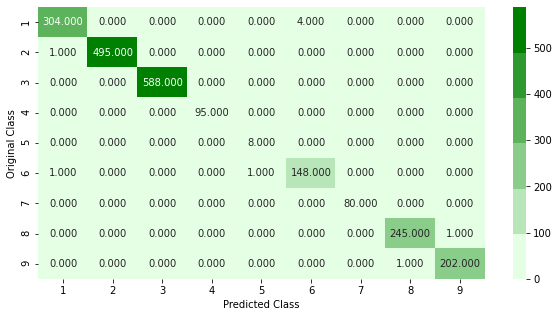

-------------------------------------------------- Precision matrix --------------------------------------------------


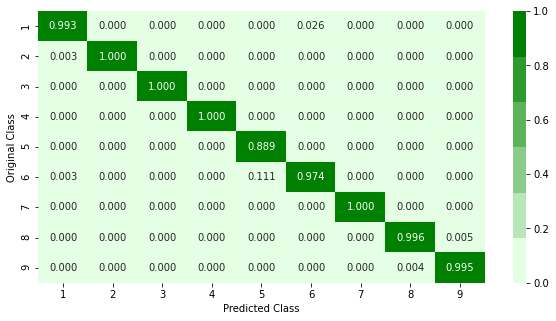

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


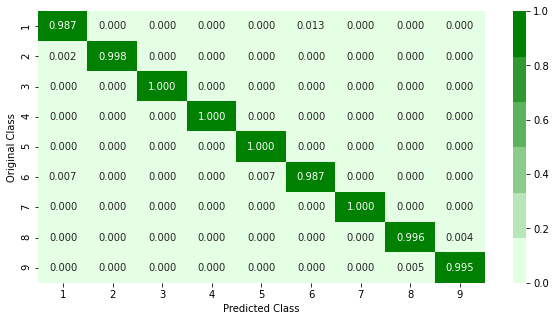

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data
# code snippet : applied AI assignemnt notebook

alpha=[10,50,100,500,1000]
cv_log_error_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,tree_method='gpu_hist')
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],tree_method='gpu_hist')
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [ ]:
# to find the best hyperparameters I am exporting the file.
X_train.to_csv('/content/drive/My Drive/assignment questions/MicrosoftMalware/x_train_1.csv')
y_train.to_csv('/content/drive/My Drive/assignment questions/MicrosoftMalware/y_train_1.csv')

In [ ]:
#finding the best parameters for XGboost classifier randomizedsearchCV
# code snippet : applied AI assignemnt notebook
x_cfl=XGBClassifier(tree_method='gpu_hist')

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,7,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=20,n_jobs=-1,cv=3)
random_cfl.fit(X_train,y_train)

#printing the best parameters
print (random_cfl.best_params_)
#NOTE : The above cell, for hyperparameter tuning of the XGBoost classifier has been done in a seperate notebook in GCP due to memoery and time constraints

NOTE : The above cell, for hyperparameter tuning of the XGBoost classifier has been done in a seperate notebook in GCP due to memoery and time constraints

In [ ]:
#XGBoost classifier for the above mentioned best parameters
# code snippet : applied AI assignemnt notebook
x_cfl=XGBClassifier(n_estimators=500,subsample=1,learning_rate=0.15,colsample_bytree=0.4,
                    max_depth=5,verbosity=1,tree_method='gpu_hist')
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.009722329815882627
cv loss 0.022361602391544916
test loss 0.020140269055092974


NOTE: The test loss has been further reduced to : 0.020140269055092974

#Feature Set-3 (byte unigrams + byte file size + asm unigrams + top 40 percent score asm image pixel intensities + top 22 percent score byte bigrams


In [ ]:
# I have computed the bigram features on GCP and then I have created a .csv file which I am using below.
#creating a dataframe for byte-bigram features from .csv file

byte_bigram_df_new=pd.read_csv('/content/drive/My Drive/red_byte_bigram_df_new.csv',index_col=False)
byte_bigram_df_new=byte_bigram_df_new.drop('Unnamed: 0',axis=1)

# byte_bigram_df_new['ID']=result_with_size['ID']
# byte_bigram_df_new = byte_bigram_df_new.merge(Y, on='ID',how='left')
print(byte_bigram_df_new.shape)
byte_bigram_df_new.head(3)

(10868, 1323)


,ID,00 00,00 01,00 02,00 03,00 04,00 05,00 06,00 07,00 08,00 0b,00 0c,00 0d,00 0e,00 0f,00 10,00 11,00 12,00 13,00 14,00 15,00 16,00 17,00 18,00 19,00 1a,00 1b,00 1c,00 1d,00 1e,00 1f,00 20,00 21,00 22,00 23,00 24,00 25,00 26,00 27,00 28,...,f8 f8,f9 00,f9 f9,fa 00,fa 06,fa fa,fb 00,fc 00,fc 02,fc 04,fc 06,fc 8b,fc f7,fc fc,fc fd,fd 00,fd 8b,fd f7,fd fc,fd fd,fd ff,fe 00,fe 02,fe 04,fe 06,fe fe,fe ff,ff 00,ff 02,ff 04,ff 12,ff 15,ff 55,ff 59,ff 75,ff 83,ff 8b,ff ff,?? ??,Class
0,2BWnr5UAQ43bEg8tKJ0y,18681,569,86,77,156,15,23,5,30,25,56,21,8,84,343,26,232,27,27,25,146,8,47,7,15,25,28,19,14,14,515,6277,86,64,24,10,14,0,158,...,0,20,0,6,0,0,8,67,2,1,0,39,10,2,8,9,9,0,0,1,93,12,0,4,0,41,589,2639,13,19,18,174,311,283,505,290,374,7224,9031,2
1,F8bN6Gx0wTRZWsHI3XLO,24885,734,2698,99,276,66,65,70,91,47,101,14,5,113,456,8,292,3,59,4,162,7,108,7,5,1,8,3,1,3,596,6,7,16,89,3,2,2,155,...,3847,14,1,6,0,1,3,119,2550,61,68,75,10,5269,7,12,10,0,0,6,99,94,2328,61,78,4810,210,1770,2201,60,63,136,306,421,930,662,416,12136,12611,2
2,Ajy4saxIMJfzOi3CcH0S,11071,209,52,50,100,59,39,21,67,23,65,35,15,55,915,26,20,12,40,30,11,8,27,9,13,6,41,16,14,15,167,1,13,5,41,37,10,12,46,...,8,18,1,14,7,2,23,53,2,14,3,74,2,15,2,12,13,0,4,0,66,35,6,4,3,2,149,710,34,69,13,134,104,79,58,66,505,1549,7418,1


In [ ]:
#https://github.com/dchad/malware-detection
#selecting the top 22 percent of the features with the highest variance using chi-square test

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2

X_t=(byte_bigram_df_new.iloc[:,1:1322]) #selecting dataframe without class and ID
y_t=y = byte_bigram_df_new.iloc[:,-1] #selecting labels

fsp = SelectPercentile(chi2, 22) #top 22 percentile features with highest chi-square test scores
X_new_20 = fsp.fit_transform(X_t,y_t)
print(X_new_20.shape)

selected_names = fsp.get_support(indices=True) #getting the indices of the features selected
selected_names = selected_names + 1

data_trimmed = byte_bigram_df_new.iloc[:,selected_names]
data_fnames = pd.DataFrame(byte_bigram_df_new['ID'])
red_byte_bigram_df_new = data_fnames.join(data_trimmed)
#red_byte_bigram_df_new['Class']=byte_bigram_df_new['Class']
red_byte_bigram_df_new.head() #returning the new dataframe


(10868, 291)


,ID,00 00,00 01,00 02,00 04,00 06,00 08,00 0f,00 10,00 12,00 16,00 1c,00 20,00 33,00 59,00 6a,00 74,00 83,00 85,00 8b,00 8d,00 a2,00 ad,00 bb,00 be,00 cf,00 e8,00 eb,00 fe,00 ff,01 00,01 01,01 02,01 04,01 06,01 f0,01 f1,01 f2,02 00,02 01,...,ec ec,ed ed,f0 01,f0 f0,f0 f1,f0 f2,f1 01,f1 f0,f1 f2,f2 01,f2 f0,f2 f1,f2 f2,f7 e0,f7 e1,f7 e2,f7 e3,f7 e6,f7 e7,f7 e8,f7 e9,f7 ea,f7 eb,f7 ee,f7 ef,f8 f8,fa 06,fa fa,fc f7,fc fc,fd 8b,fd f7,fd fd,fe fe,fe ff,ff 00,ff 75,ff 8b,ff ff,?? ??
0,2BWnr5UAQ43bEg8tKJ0y,18681,569,86,156,23,30,84,343,232,146,28,515,107,122,70,138,216,66,379,106,6,3,14,13,8,167,80,65,1968,814,115,55,5,0,0,6,0,117,52,...,0,0,4,2,7,0,0,0,4,0,0,0,0,0,3,0,0,4,0,0,0,0,1,0,0,0,0,0,10,2,9,0,1,41,589,2639,505,374,7224,9031
1,F8bN6Gx0wTRZWsHI3XLO,24885,734,2698,276,65,91,113,456,292,162,8,596,130,191,108,229,233,139,306,130,3,8,17,27,13,158,163,130,2807,853,5550,2752,90,67,52,0,0,2737,2755,...,4894,0,62,4378,5,0,0,2,4,1,0,1,2,0,8,0,1,2,2,1,0,1,1,1,0,3847,0,1,10,5269,10,0,6,4810,210,1770,930,416,12136,12611
2,Ajy4saxIMJfzOi3CcH0S,11071,209,52,100,39,67,55,915,20,11,41,167,68,72,51,221,107,77,496,119,6,5,7,10,9,287,79,37,709,395,47,5,10,5,3,3,2,123,10,...,3,2,5,8,1,2,1,2,2,2,1,3,1,3,2,0,0,2,0,2,4,0,5,1,1,8,7,2,2,15,13,0,0,2,149,710,58,505,1549,7418
3,5su2fIARtLqUzSdQgDB9,104880,724,569,721,602,774,667,534,494,468,438,519,586,684,698,888,730,843,974,944,507,433,466,444,412,1001,519,553,1829,749,2237,50,70,53,32,26,17,618,43,...,541,3,26,380,7,7,21,9,6,18,7,3,7,11,9,6,7,18,10,53,8,5,17,7,3,1155,17,267,17,916,39,15,388,978,441,1812,200,386,11406,541
4,g9A5fmc63Sth41uoBLEz,30768,671,440,208,125,127,276,551,370,163,118,592,356,252,216,259,517,191,686,271,74,55,46,58,64,403,233,263,1646,1064,401,330,135,90,65,50,55,539,347,...,2,0,57,23,5,0,53,0,4,42,0,0,2,0,4,0,2,2,1,0,0,0,6,0,4,3,0,0,3,3,77,0,4,20,728,984,989,800,5239,10343


In [ ]:
#creating a dataframe for asm pixel intensity features from .csv file
asm_img_800=pd.read_csv('/content/drive/My Drive/assignment questions/MicrosoftMalware/asm_image_df.csv',index_col=False)
print(asm_img_800.shape)
asm_img_800.head(10)

(10868, 801)


,ID,Pixel0,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,Pixel10,Pixel11,Pixel12,Pixel13,Pixel14,Pixel15,Pixel16,Pixel17,Pixel18,Pixel19,Pixel20,Pixel21,Pixel22,Pixel23,Pixel24,Pixel25,Pixel26,Pixel27,Pixel28,Pixel29,Pixel30,Pixel31,Pixel32,Pixel33,Pixel34,Pixel35,Pixel36,Pixel37,Pixel38,...,Pixel760,Pixel761,Pixel762,Pixel763,Pixel764,Pixel765,Pixel766,Pixel767,Pixel768,Pixel769,Pixel770,Pixel771,Pixel772,Pixel773,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783,Pixel784,Pixel785,Pixel786,Pixel787,Pixel788,Pixel789,Pixel790,Pixel791,Pixel792,Pixel793,Pixel794,Pixel795,Pixel796,Pixel797,Pixel798,Pixel799
0,jExBgXmKlhA4URac86kQ,46,116,101,120,116,58,48,48,52,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,13,10,46,116,101,120,116,58,48,48,52,...,32,58,32,80,111,114,116,97,98,108,101,9,101,120,101,99,117,116,97,98,108,101,32,102,111,114,32,56,48,51,56,54,32,40,80,69,41,13,10,46
1,0RSW8EmilbznyYPIrgvD,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,109,109,120,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,9,9,46,109,111,100,101,108,32,102,108,97,116
2,2zsVAYPQrf3GFoD5JhC0,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
3,E3sij5MlNGadWfcSDvQw,46,116,101,120,116,58,48,48,52,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,13,10,46,116,101,120,116,58,48,48,52,...,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,32,70,111,114,109,97,116,9,32,32,32,32,32,58,32,80,111,114,116,97,98
4,bDfQnleI6rqp5Nw9GC3O,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,109,109,120,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,9,9,46,109,111,100,101,108,32,102,108,97,116
5,9joLAv30xuTSM4fqNbJZ,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,9,59,32,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
6,8cM57th1BVwar2szTENJ,46,116,101,120,116,58,48,48,52,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,13,10,46,116,101,120,116,58,48,48,52,...,32,58,32,80,111,114,116,97,98,108,101,9,101,120,101,99,117,116,97,98,108,101,32,102,111,114,32,56,48,51,56,54,32,40,80,69,41,13,10,46
7,2i5N9Ftj3xoySflKzbAC,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,9,9,46,109,109,120,13,10,72,69,65,68,69,82,58,48,48
8,lkqEXK4NrYSseRTt0Gb3,72,69,65,68,69,82,58,49,48,48,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,49,48,48,48,48,48,48,...,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
9,6IrZu0ynlqf4otPBA7HT,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61


In [ ]:
#https://github.com/dchad/malware-detection
#selecting the top 25 percent of the features with the highest variance using chi-square test

X_t=(asm_img_800.iloc[:,1:801]) #selecting dataframe without class and ID
y_t=y = asm_img_800.iloc[:,1] #selecting labels

fsp = SelectPercentile(chi2, 40) #top 40 percentile features with highest chi-square test scores
X_new_20 = fsp.fit_transform(X_t,y_t)
print(X_new_20.shape)

selected_names = fsp.get_support(indices=True) #getting the indices of the features selected
selected_names = selected_names + 1

data_trimmed = asm_img_800.iloc[:,selected_names]
data_fnames = pd.DataFrame(asm_img_800['ID'])
red_asm_img_800 = data_fnames.join(data_trimmed)
red_asm_img_800.head() #returning the new dataframe

(10868, 320)


,ID,Pixel1,Pixel3,Pixel4,Pixel14,Pixel20,Pixel21,Pixel23,Pixel24,Pixel25,Pixel26,Pixel28,Pixel29,Pixel31,Pixel32,Pixel33,Pixel34,Pixel40,Pixel41,Pixel42,Pixel43,Pixel47,Pixel48,Pixel49,Pixel124,Pixel125,Pixel134,Pixel135,Pixel137,Pixel138,Pixel139,Pixel140,Pixel141,Pixel142,Pixel143,Pixel144,Pixel145,Pixel146,Pixel147,Pixel150,...,Pixel690,Pixel691,Pixel692,Pixel694,Pixel695,Pixel718,Pixel719,Pixel721,Pixel722,Pixel723,Pixel724,Pixel725,Pixel728,Pixel729,Pixel730,Pixel733,Pixel735,Pixel739,Pixel742,Pixel743,Pixel750,Pixel751,Pixel752,Pixel753,Pixel754,Pixel760,Pixel762,Pixel773,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel783,Pixel784,Pixel785,Pixel792
0,jExBgXmKlhA4URac86kQ,116,120,116,9,32,32,32,32,32,32,13,10,116,101,120,116,49,48,48,48,9,9,9,45,45,13,10,116,101,120,116,58,48,48,52,48,49,48,9,...,45,45,45,45,45,13,10,116,101,120,116,58,52,48,49,48,9,9,32,32,111,114,109,97,116,32,32,120,101,99,117,116,97,98,108,101,102,111,114,32
1,0RSW8EmilbznyYPIrgvD,69,68,69,48,9,9,13,10,72,69,68,69,58,48,48,52,9,9,9,9,59,32,43,13,10,48,52,48,48,48,48,9,9,9,9,9,9,9,124,...,68,69,82,48,48,48,9,9,9,9,9,9,46,54,56,13,72,69,48,48,9,9,9,9,9,109,120,48,52,48,48,48,48,48,9,9,9,9,9,100
2,2zsVAYPQrf3GFoD5JhC0,69,68,69,48,9,9,13,10,72,69,68,69,58,48,48,52,9,9,9,9,59,32,43,13,10,48,52,48,48,48,48,9,9,9,9,9,9,9,124,...,102,108,97,13,10,82,58,48,52,48,48,48,9,9,9,9,59,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
3,E3sij5MlNGadWfcSDvQw,116,120,116,9,32,32,32,32,32,32,13,10,116,101,120,116,49,48,48,48,9,9,9,45,45,13,10,116,101,120,116,58,48,48,52,48,49,48,9,...,45,45,45,45,45,13,10,116,101,120,116,58,52,48,49,48,9,9,32,32,10,46,116,101,120,48,48,32,32,32,32,32,59,32,70,111,109,97,116,58
4,bDfQnleI6rqp5Nw9GC3O,69,68,69,48,9,9,13,10,72,69,68,69,58,48,48,52,9,9,9,9,59,32,43,13,10,48,52,48,48,48,48,9,9,9,9,9,9,9,124,...,68,69,82,48,48,48,9,9,9,9,9,9,46,54,56,13,72,69,48,48,9,9,9,9,9,109,120,48,52,48,48,48,48,48,9,9,9,9,9,100


In [ ]:
#merging all the above features into a single dataframe feature_set_1
feature_set_3 = result_with_size.merge(red_byte_bigram_df_new, on='ID',how='left')
feature_set_3 =feature_set_3.merge(asm_feat, on='ID',how='left')
feature_set_3 =feature_set_3.merge(red_asm_img_800, on='ID',how='left')
feature_set_3.head(2)

,ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,...,Pixel690,Pixel691,Pixel692,Pixel694,Pixel695,Pixel718,Pixel719,Pixel721,Pixel722,Pixel723,Pixel724,Pixel725,Pixel728,Pixel729,Pixel730,Pixel733,Pixel735,Pixel739,Pixel742,Pixel743,Pixel750,Pixel751,Pixel752,Pixel753,Pixel754,Pixel760,Pixel762,Pixel773,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel783,Pixel784,Pixel785,Pixel792
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,3211,3546,4038,4096,3218,3032,3269,2740,3459,2767,3354,4049,3184,3495,3139,2810,3444,3130,3786,3682,2665,3100,2990,3175,2826,4295,8565,4002,3105,...,82,58,48,52,48,97,116,10,72,69,65,68,58,48,48,48,48,72,68,69,48,48,48,48,9,9,32,61,61,61,61,61,61,61,61,61,61,61,61,61
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,340,6649,8660,447,218,6869,8869,228,352581,187,12034,353,349,154,6735,307,278,209,688,266,321,213,12372,309,196,296,8979,301,288,...,45,45,45,45,45,13,10,116,101,120,116,58,52,48,49,48,9,9,32,32,111,114,109,97,116,32,32,120,101,99,117,116,97,98,108,101,102,111,114,32


In [ ]:
#labels for the data set
y=feature_set_3['Class']
#dropping the class and ID columns too
feature_set_3=feature_set_3.drop('Class',axis=1)
feature_set_3=feature_set_3.drop('ID',axis=1)
print( ' Shape of feature  set 1 : ',feature_set_3.shape)
feature_set_3.head(2)

 Shape of feature  set 1 :  (10868, 920)


,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,...,Pixel690,Pixel691,Pixel692,Pixel694,Pixel695,Pixel718,Pixel719,Pixel721,Pixel722,Pixel723,Pixel724,Pixel725,Pixel728,Pixel729,Pixel730,Pixel733,Pixel735,Pixel739,Pixel742,Pixel743,Pixel750,Pixel751,Pixel752,Pixel753,Pixel754,Pixel760,Pixel762,Pixel773,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel783,Pixel784,Pixel785,Pixel792
0,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,3211,3546,4038,4096,3218,3032,3269,2740,3459,2767,3354,4049,3184,3495,3139,2810,3444,3130,3786,3682,2665,3100,2990,3175,2826,4295,8565,4002,3105,2983,...,82,58,48,52,48,97,116,10,72,69,65,68,58,48,48,48,48,72,68,69,48,48,48,48,9,9,32,61,61,61,61,61,61,61,61,61,61,61,61,61
1,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,340,6649,8660,447,218,6869,8869,228,352581,187,12034,353,349,154,6735,307,278,209,688,266,321,213,12372,309,196,296,8979,301,288,282,...,45,45,45,45,45,13,10,116,101,120,116,58,52,48,49,48,9,9,32,32,111,114,109,97,116,32,32,120,101,99,117,116,97,98,108,101,102,111,114,32


In [ ]:
# https://stackoverflow.com/a/29651514
#for normalizing all the features
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
#normalizing all the features and filling the NaN values with 0
result_3 = normalize(feature_set_3)
result_3=result_3.fillna(0)
result_3.head(2)

,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,...,Pixel690,Pixel691,Pixel692,Pixel694,Pixel695,Pixel718,Pixel719,Pixel721,Pixel722,Pixel723,Pixel724,Pixel725,Pixel728,Pixel729,Pixel730,Pixel733,Pixel735,Pixel739,Pixel742,Pixel743,Pixel750,Pixel751,Pixel752,Pixel753,Pixel754,Pixel760,Pixel762,Pixel773,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel783,Pixel784,Pixel785,Pixel792
0,0.262806,0.005498,0.001567,0.002067,0.002048,0.001835,0.002058,0.002946,0.002638,0.003531,0.006862,0.001947,0.006293,0.005456,0.004779,0.005338,0.001887,0.005353,0.004134,0.002097,0.003493,0.008066,0.003777,0.004430,0.002300,0.002007,0.003331,0.002480,0.002947,0.005665,0.005371,0.003437,0.005760,0.002766,0.002770,0.004628,0.006888,0.003829,0.005878,0.003316,...,0.581395,0.436893,0.367925,0.380531,0.423913,0.830189,1.000000,0.009346,0.63,0.540541,0.504505,0.522124,0.457944,0.367925,0.351351,0.382353,0.364486,0.567568,0.621053,0.606061,0.364486,0.367925,0.364486,0.382353,0.000000,0.000000,0.207207,0.448598,0.52,0.553191,0.460177,0.464286,0.468468,0.485981,0.468468,0.477064,0.52,0.468468,0.477064,0.481481
1,0.017358,0.011737,0.004033,0.003876,0.005303,0.003873,0.004747,0.006984,0.008267,0.000394,0.000727,0.003650,0.013496,0.000595,0.000324,0.012093,0.005120,0.000445,0.421371,0.000142,0.012532,0.000703,0.000414,0.000195,0.004935,0.000219,0.000269,0.000166,0.000535,0.000409,0.000647,0.000236,0.023833,0.000269,0.000192,0.000319,0.007220,0.000288,0.000545,0.000313,...,0.151163,0.310680,0.339623,0.318584,0.391304,0.037736,0.009346,1.000000,0.92,1.000000,0.963964,0.433628,0.401869,0.367925,0.360360,0.382353,0.000000,0.000000,0.242105,0.232323,0.953271,0.990566,0.934579,0.862745,0.963964,0.214953,0.207207,1.000000,0.92,0.957447,0.955752,0.955357,0.792793,0.831776,0.891892,0.844037,0.93,0.918919,0.963303,0.212963


In [ ]:
#reference: given microsoft assignment

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result_3, y,stratify=y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

#printing the no. of datapoints in each set
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

#printing the shape of each set
print('Shape of train data:', X_train.shape)
print('Shape of test data:', X_test.shape)
print('Shape of cross validation data:', X_cv.shape)

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739
Shape of train data: (6955, 920)
Shape of test data: (2174, 920)
Shape of cross validation data: (1739, 920)



log_loss for c =  10 is 0.026075806854025205
log_loss for c =  50 is 0.02401194434208394
log_loss for c =  100 is 0.024561495087012723
log_loss for c =  500 is 0.025839094712236128
log_loss for c =  1000 is 0.02565828654310455


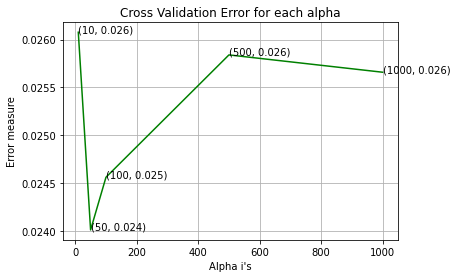

For values of best alpha =  50 The train log loss is: 0.010383647429620994
For values of best alpha =  50 The cross validation log loss is: 0.02401194434208394
For values of best alpha =  50 The test log loss is: 0.025784973178580497
Number of misclassified points  0.45998160073597055
-------------------------------------------------- Confusion matrix --------------------------------------------------


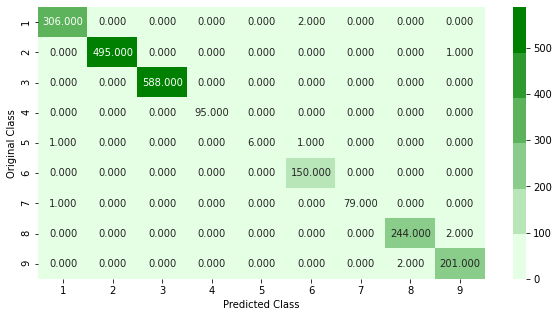

-------------------------------------------------- Precision matrix --------------------------------------------------


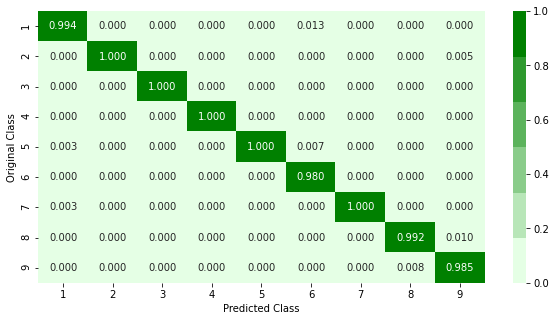

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


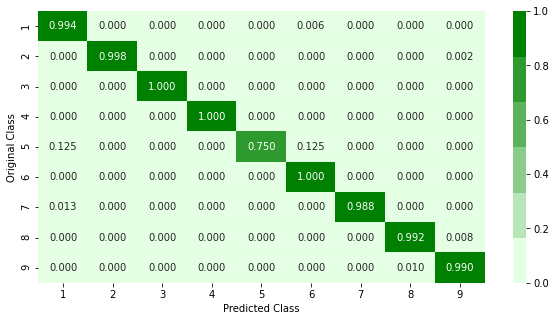

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
#reference: given AAIC microsoft assignment

alpha=[10,50,100,500,1000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))


log_loss for c =  10 is 0.060657305209170766
log_loss for c =  50 is 0.03074832518799437
log_loss for c =  100 is 0.02494685635222881
log_loss for c =  500 is 0.023401484752062756
log_loss for c =  1000 is 0.02336001494669532


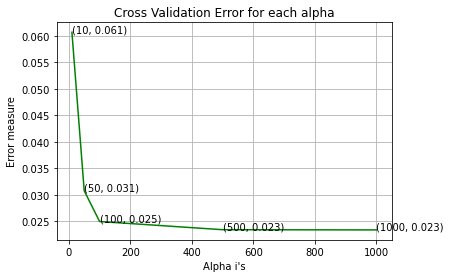

For values of best alpha =  1000 The train log loss is: 0.009942071327118641
For values of best alpha =  1000 The cross validation log loss is: 0.02336001494669532
For values of best alpha =  1000 The test log loss is: 0.019830903384301456


NameError: ignored

In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data
#reference: given AAIC microsoft assignment
# -----------------------

alpha=[10,50,100,500,1000]
cv_log_error_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,tree_method='gpu_hist')
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],tree_method='gpu_hist')
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


Number of misclassified points  0.27598896044158233
-------------------------------------------------- Confusion matrix --------------------------------------------------


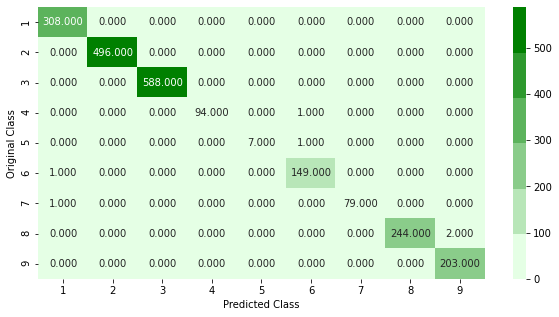

-------------------------------------------------- Precision matrix --------------------------------------------------


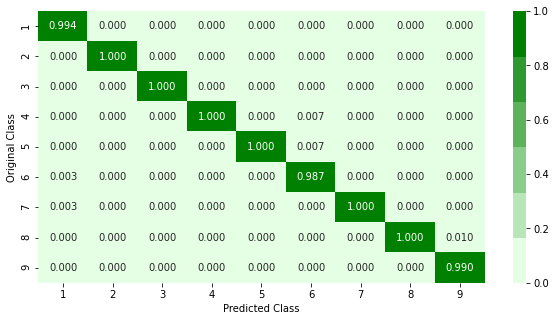

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


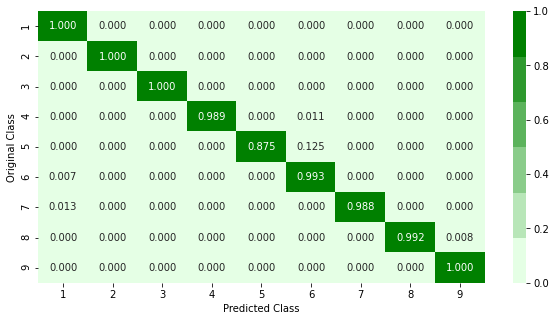

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
#checking which class datapoints has not been correctly classified and their repective percentage
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [ ]:
#XGBoost classifier for the parameters ( did some experiment and manually tuned it)
#reference: given AAIC microsoft assignment

x_cfl=XGBClassifier(n_estimators=100,subsample=1,learning_rate=0.15,colsample_bytree=0.2,
                    max_depth=3,verbosity=1,tree_method='gpu_hist')
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.00903737998127111
cv loss 0.02185754917777857
test loss 0.014627183088962836


# test log loss reduced to <=0.015!!

----------------------------------------------------------------------------------------------------------------

# ( Experiment )
#Feature Set-4 (byte unigrams + byte file size + asm unigrams + asm image pixel intensities + entropy of byte file + len of byte files

In [ ]:
# I have computed the bigram features on GCP and then I have created a .csv file which I am using below.
#creating a dataframe for byte-bigram features from .csv file

byte_bigram_df_new=pd.read_csv('/content/drive/My Drive/red_byte_bigram_df_new.csv',index_col=False)
byte_bigram_df_new=byte_bigram_df_new.drop('Unnamed: 0',axis=1)

print(byte_bigram_df_new.shape)
byte_bigram_df_new.head(3)

(10868, 1323)


,ID,00 00,00 01,00 02,00 03,00 04,00 05,00 06,00 07,00 08,00 0b,00 0c,00 0d,00 0e,00 0f,00 10,00 11,00 12,00 13,00 14,00 15,00 16,00 17,00 18,00 19,00 1a,00 1b,00 1c,00 1d,00 1e,00 1f,00 20,00 21,00 22,00 23,00 24,00 25,00 26,00 27,00 28,...,f8 f8,f9 00,f9 f9,fa 00,fa 06,fa fa,fb 00,fc 00,fc 02,fc 04,fc 06,fc 8b,fc f7,fc fc,fc fd,fd 00,fd 8b,fd f7,fd fc,fd fd,fd ff,fe 00,fe 02,fe 04,fe 06,fe fe,fe ff,ff 00,ff 02,ff 04,ff 12,ff 15,ff 55,ff 59,ff 75,ff 83,ff 8b,ff ff,?? ??,Class
0,2BWnr5UAQ43bEg8tKJ0y,18681,569,86,77,156,15,23,5,30,25,56,21,8,84,343,26,232,27,27,25,146,8,47,7,15,25,28,19,14,14,515,6277,86,64,24,10,14,0,158,...,0,20,0,6,0,0,8,67,2,1,0,39,10,2,8,9,9,0,0,1,93,12,0,4,0,41,589,2639,13,19,18,174,311,283,505,290,374,7224,9031,2
1,F8bN6Gx0wTRZWsHI3XLO,24885,734,2698,99,276,66,65,70,91,47,101,14,5,113,456,8,292,3,59,4,162,7,108,7,5,1,8,3,1,3,596,6,7,16,89,3,2,2,155,...,3847,14,1,6,0,1,3,119,2550,61,68,75,10,5269,7,12,10,0,0,6,99,94,2328,61,78,4810,210,1770,2201,60,63,136,306,421,930,662,416,12136,12611,2
2,Ajy4saxIMJfzOi3CcH0S,11071,209,52,50,100,59,39,21,67,23,65,35,15,55,915,26,20,12,40,30,11,8,27,9,13,6,41,16,14,15,167,1,13,5,41,37,10,12,46,...,8,18,1,14,7,2,23,53,2,14,3,74,2,15,2,12,13,0,4,0,66,35,6,4,3,2,149,710,34,69,13,134,104,79,58,66,505,1549,7418,1


In [ ]:
#https://github.com/dchad/malware-detection
#selecting the top 20 percent of the features with the highest variance using chi-square test


from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2

X_t=(byte_bigram_df_new.iloc[:,1:1322])
y_t=y = byte_bigram_df_new.iloc[:,-1]

fsp = SelectPercentile(chi2, 20)
X_new_20 = fsp.fit_transform(X_t,y_t)
print(X_new_20.shape)

selected_names = fsp.get_support(indices=True)
selected_names = selected_names + 1

data_trimmed = byte_bigram_df_new.iloc[:,selected_names]
data_fnames = pd.DataFrame(byte_bigram_df_new['ID'])
red_byte_bigram_df_new = data_fnames.join(data_trimmed)
#red_byte_bigram_df_new['Class']=byte_bigram_df_new['Class']
red_byte_bigram_df_new.head()


(10868, 264)


,ID,00 00,00 01,00 02,00 04,00 06,00 08,00 10,00 12,00 16,00 20,00 33,00 59,00 6a,00 74,00 83,00 85,00 8b,00 8d,00 a2,00 ad,00 cf,00 e8,00 eb,00 fe,00 ff,01 00,01 01,01 02,01 04,01 06,01 f0,01 f1,01 f2,02 00,02 01,02 02,02 03,02 04,02 06,...,ec ec,ed ed,f0 01,f0 f0,f0 f1,f0 f2,f1 01,f1 f0,f1 f2,f2 01,f2 f0,f2 f1,f2 f2,f7 e0,f7 e1,f7 e2,f7 e3,f7 e6,f7 e7,f7 e8,f7 e9,f7 ea,f7 eb,f7 ee,f7 ef,f8 f8,fa 06,fa fa,fc f7,fc fc,fd 8b,fd f7,fd fd,fe fe,fe ff,ff 00,ff 75,ff 8b,ff ff,?? ??
0,2BWnr5UAQ43bEg8tKJ0y,18681,569,86,156,23,30,343,232,146,515,107,122,70,138,216,66,379,106,6,3,8,167,80,65,1968,814,115,55,5,0,0,6,0,117,52,2,6,5,1,...,0,0,4,2,7,0,0,0,4,0,0,0,0,0,3,0,0,4,0,0,0,0,1,0,0,0,0,0,10,2,9,0,1,41,589,2639,505,374,7224,9031
1,F8bN6Gx0wTRZWsHI3XLO,24885,734,2698,276,65,91,456,292,162,596,130,191,108,229,233,139,306,130,3,8,13,158,163,130,2807,853,5550,2752,90,67,52,0,0,2737,2755,8481,2040,2849,3489,...,4894,0,62,4378,5,0,0,2,4,1,0,1,2,0,8,0,1,2,2,1,0,1,1,1,0,3847,0,1,10,5269,10,0,6,4810,210,1770,930,416,12136,12611
2,Ajy4saxIMJfzOi3CcH0S,11071,209,52,100,39,67,915,20,11,167,68,72,51,221,107,77,496,119,6,5,9,287,79,37,709,395,47,5,10,5,3,3,2,123,10,5,7,5,2,...,3,2,5,8,1,2,1,2,2,2,1,3,1,3,2,0,0,2,0,2,4,0,5,1,1,8,7,2,2,15,13,0,0,2,149,710,58,505,1549,7418
3,5su2fIARtLqUzSdQgDB9,104880,724,569,721,602,774,534,494,468,519,586,684,698,888,730,843,974,944,507,433,412,1001,519,553,1829,749,2237,50,70,53,32,26,17,618,43,988,29,45,33,...,541,3,26,380,7,7,21,9,6,18,7,3,7,11,9,6,7,18,10,53,8,5,17,7,3,1155,17,267,17,916,39,15,388,978,441,1812,200,386,11406,541
4,g9A5fmc63Sth41uoBLEz,30768,671,440,208,125,127,551,370,163,592,356,252,216,259,517,191,686,271,74,55,64,403,233,263,1646,1064,401,330,135,90,65,50,55,539,347,282,229,124,105,...,2,0,57,23,5,0,53,0,4,42,0,0,2,0,4,0,2,2,1,0,0,0,6,0,4,3,0,0,3,3,77,0,4,20,728,984,989,800,5239,10343


In [ ]:
#creating a dataframe for asm pixel intensity features from .csv file
asm_img_800=pd.read_csv('/content/drive/My Drive/assignment questions/MicrosoftMalware/asm_image_df.csv',index_col=False)
print(asm_img_800.shape)
asm_img_800.head(10)

(10868, 801)


,ID,Pixel0,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,Pixel10,Pixel11,Pixel12,Pixel13,Pixel14,Pixel15,Pixel16,Pixel17,Pixel18,Pixel19,Pixel20,Pixel21,Pixel22,Pixel23,Pixel24,Pixel25,Pixel26,Pixel27,Pixel28,Pixel29,Pixel30,Pixel31,Pixel32,Pixel33,Pixel34,Pixel35,Pixel36,Pixel37,Pixel38,...,Pixel760,Pixel761,Pixel762,Pixel763,Pixel764,Pixel765,Pixel766,Pixel767,Pixel768,Pixel769,Pixel770,Pixel771,Pixel772,Pixel773,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783,Pixel784,Pixel785,Pixel786,Pixel787,Pixel788,Pixel789,Pixel790,Pixel791,Pixel792,Pixel793,Pixel794,Pixel795,Pixel796,Pixel797,Pixel798,Pixel799
0,jExBgXmKlhA4URac86kQ,46,116,101,120,116,58,48,48,52,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,13,10,46,116,101,120,116,58,48,48,52,...,32,58,32,80,111,114,116,97,98,108,101,9,101,120,101,99,117,116,97,98,108,101,32,102,111,114,32,56,48,51,56,54,32,40,80,69,41,13,10,46
1,0RSW8EmilbznyYPIrgvD,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,109,109,120,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,9,9,46,109,111,100,101,108,32,102,108,97,116
2,2zsVAYPQrf3GFoD5JhC0,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
3,E3sij5MlNGadWfcSDvQw,46,116,101,120,116,58,48,48,52,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,13,10,46,116,101,120,116,58,48,48,52,...,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,32,70,111,114,109,97,116,9,32,32,32,32,32,58,32,80,111,114,116,97,98
4,bDfQnleI6rqp5Nw9GC3O,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,109,109,120,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,9,9,46,109,111,100,101,108,32,102,108,97,116
5,9joLAv30xuTSM4fqNbJZ,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,9,59,32,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
6,8cM57th1BVwar2szTENJ,46,116,101,120,116,58,48,48,52,48,49,48,48,48,9,9,9,9,9,9,32,32,32,32,32,32,32,59,13,10,46,116,101,120,116,58,48,48,52,...,32,58,32,80,111,114,116,97,98,108,101,9,101,120,101,99,117,116,97,98,108,101,32,102,111,114,32,56,48,51,56,54,32,40,80,69,41,13,10,46
7,2i5N9Ftj3xoySflKzbAC,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,9,9,46,109,109,120,13,10,72,69,65,68,69,82,58,48,48
8,lkqEXK4NrYSseRTt0Gb3,72,69,65,68,69,82,58,49,48,48,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,49,48,48,48,48,48,48,...,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
9,6IrZu0ynlqf4otPBA7HT,72,69,65,68,69,82,58,48,48,52,48,48,48,48,48,9,9,9,9,9,9,9,59,13,10,72,69,65,68,69,82,58,48,48,52,48,48,48,48,...,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61


In [ ]:
#https://github.com/dchad/malware-detection
#selecting the top 35 percent of the features with the highest variance using chi-square test

X_t=(asm_img_800.iloc[:,1:801])
y_t=y = asm_img_800.iloc[:,1]

fsp = SelectPercentile(chi2, 35)
X_new_20 = fsp.fit_transform(X_t,y_t)
print(X_new_20.shape)

selected_names = fsp.get_support(indices=True)
selected_names = selected_names + 1

data_trimmed = asm_img_800.iloc[:,selected_names]
data_fnames = pd.DataFrame(asm_img_800['ID'])
red_asm_img_800 = data_fnames.join(data_trimmed)
red_asm_img_800.head()

(10868, 280)


,ID,Pixel1,Pixel3,Pixel14,Pixel20,Pixel21,Pixel24,Pixel28,Pixel29,Pixel31,Pixel32,Pixel33,Pixel34,Pixel40,Pixel41,Pixel42,Pixel43,Pixel47,Pixel49,Pixel124,Pixel125,Pixel134,Pixel135,Pixel137,Pixel138,Pixel139,Pixel140,Pixel141,Pixel142,Pixel143,Pixel144,Pixel145,Pixel146,Pixel147,Pixel150,Pixel154,Pixel155,Pixel156,Pixel157,Pixel159,...,Pixel621,Pixel626,Pixel628,Pixel629,Pixel630,Pixel631,Pixel632,Pixel633,Pixel634,Pixel646,Pixel656,Pixel658,Pixel674,Pixel677,Pixel691,Pixel692,Pixel694,Pixel695,Pixel718,Pixel719,Pixel721,Pixel722,Pixel723,Pixel724,Pixel728,Pixel729,Pixel735,Pixel739,Pixel750,Pixel751,Pixel752,Pixel753,Pixel754,Pixel762,Pixel776,Pixel777,Pixel778,Pixel779,Pixel784,Pixel785
0,jExBgXmKlhA4URac86kQ,116,120,9,32,32,32,13,10,116,101,120,116,49,48,48,48,9,9,45,45,13,10,116,101,120,116,58,48,48,52,48,49,48,9,9,9,32,32,32,...,48,48,9,9,9,9,9,9,32,45,45,45,45,45,45,45,45,45,13,10,116,101,120,116,52,48,9,9,111,114,109,97,116,32,117,116,97,98,111,114
1,0RSW8EmilbznyYPIrgvD,69,68,48,9,9,10,68,69,58,48,48,52,9,9,9,9,59,43,13,10,48,52,48,48,48,48,9,9,9,9,9,9,9,124,84,104,105,115,102,...,9,117,101,9,117,110,105,46,105,105,105,32,32,9,69,82,48,48,48,9,9,9,9,9,46,54,72,69,9,9,9,9,9,120,48,48,48,48,9,9
2,2zsVAYPQrf3GFoD5JhC0,69,68,48,9,9,10,68,69,58,48,48,52,9,9,9,9,59,43,13,10,48,52,48,48,48,48,9,9,9,9,9,9,9,124,84,104,105,115,102,...,9,112,10,72,69,65,68,69,82,9,120,10,9,9,108,97,13,10,82,58,48,52,48,48,9,9,59,61,61,61,61,61,61,61,61,61,61,61,61,61
3,E3sij5MlNGadWfcSDvQw,116,120,9,32,32,32,13,10,116,101,120,116,49,48,48,48,9,9,45,45,13,10,116,101,120,116,58,48,48,52,48,49,48,9,9,9,32,32,32,...,48,48,9,9,9,9,9,9,32,45,45,45,45,45,45,45,45,45,13,10,116,101,120,116,52,48,9,9,10,46,116,101,120,48,32,32,59,32,97,116
4,bDfQnleI6rqp5Nw9GC3O,69,68,48,9,9,10,68,69,58,48,48,52,9,9,9,9,59,43,13,10,48,52,48,48,48,48,9,9,9,9,9,9,9,124,84,104,105,115,102,...,9,117,101,9,117,110,105,46,105,105,105,32,32,9,69,82,48,48,48,9,9,9,9,9,46,54,72,69,9,9,9,9,9,120,48,48,48,48,9,9


In [ ]:
#loading the entropy feature of the byte file
entropy_file=pd.read_csv('/content/drive/My Drive/assignment questions/MicrosoftMalware/train-malware-features-byte.csv',index_col=False)
entropy_file.columns=['ID','entropy','filesize']
entropy_file=entropy_file.drop(['filesize'],axis=1)
entropy_file.head()

,ID,entropy
0,e9d614aPtXTmKu7JjfOE,0.476092
1,0dkuzUXLTEFwW71vP5bS,0.473898
2,5cVTmPKBAp9Llzbh2MtI,0.357425
3,80ZfO5UGkLI4Scj3eQwh,0.767887
4,8kORlw25hI69eu7jEfVy,0.476050


In [ ]:
#creating a dataframe for len of a byte file feature from .csv file
len_of_byte=pd.read_csv('/content/drive/My Drive/assignment questions/MicrosoftMalware/len_of_byte.csv',index_col=False)
len_of_byte=len_of_byte.drop('Unnamed: 0',axis=1)
len_of_byte.columns = ['len_of_byte']
len_of_byte['ID']=result_with_size['ID']
len_of_byte.head(3)

,len_of_byte,ID
0,7704576,01azqd4InC7m9JpocGv5
1,7065600,01IsoiSMh5gxyDYTl4CB
2,626688,01jsnpXSAlgw6aPeDxrU


In [ ]:
#merging all the above features into a single dataframe feature_set_1
feature_set_3 = result_with_size.merge(red_byte_bigram_df_new, on='ID',how='left')
feature_set_3 =feature_set_3.merge(asm_feat, on='ID',how='left')
feature_set_3 =feature_set_3.merge(red_asm_img_800, on='ID',how='left')
feature_set_3 =feature_set_3.merge(entropy_file, on='ID',how='left')
feature_set_3 =feature_set_3.merge(len_of_byte, on='ID',how='left')
feature_set_3.head(2)

,ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,...,Pixel628,Pixel629,Pixel630,Pixel631,Pixel632,Pixel633,Pixel634,Pixel646,Pixel656,Pixel658,Pixel674,Pixel677,Pixel691,Pixel692,Pixel694,Pixel695,Pixel718,Pixel719,Pixel721,Pixel722,Pixel723,Pixel724,Pixel728,Pixel729,Pixel735,Pixel739,Pixel750,Pixel751,Pixel752,Pixel753,Pixel754,Pixel762,Pixel776,Pixel777,Pixel778,Pixel779,Pixel784,Pixel785,entropy,len_of_byte
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,3211,3546,4038,4096,3218,3032,3269,2740,3459,2767,3354,4049,3184,3495,3139,2810,3444,3130,3786,3682,2665,3100,2990,3175,2826,4295,8565,4002,3105,...,69,82,58,48,48,52,48,9,69,68,9,9,58,48,52,48,97,116,10,72,69,65,58,48,48,72,48,48,48,48,9,32,61,61,61,61,61,61,0.703961,7704576
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,340,6649,8660,447,218,6869,8869,228,352581,187,12034,353,349,154,6735,307,278,209,688,266,321,213,12372,309,196,296,8979,301,288,...,9,9,9,9,9,9,32,45,45,45,45,45,45,45,45,45,13,10,116,101,120,116,52,48,9,9,111,114,109,97,116,32,117,116,97,98,111,114,0.614952,7065600


In [ ]:
#labels for the data set
y=feature_set_3['Class']
#dropping the class and ID columns too
feature_set_3=feature_set_3.drop('Class',axis=1)
feature_set_3=feature_set_3.drop('ID',axis=1)
print( ' Shape of feature  set 1 : ',feature_set_3.shape)
feature_set_3.head(2)

 Shape of feature  set 1 :  (10868, 855)


,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,...,Pixel628,Pixel629,Pixel630,Pixel631,Pixel632,Pixel633,Pixel634,Pixel646,Pixel656,Pixel658,Pixel674,Pixel677,Pixel691,Pixel692,Pixel694,Pixel695,Pixel718,Pixel719,Pixel721,Pixel722,Pixel723,Pixel724,Pixel728,Pixel729,Pixel735,Pixel739,Pixel750,Pixel751,Pixel752,Pixel753,Pixel754,Pixel762,Pixel776,Pixel777,Pixel778,Pixel779,Pixel784,Pixel785,entropy,len_of_byte
0,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,3211,3546,4038,4096,3218,3032,3269,2740,3459,2767,3354,4049,3184,3495,3139,2810,3444,3130,3786,3682,2665,3100,2990,3175,2826,4295,8565,4002,3105,2983,...,69,82,58,48,48,52,48,9,69,68,9,9,58,48,52,48,97,116,10,72,69,65,58,48,48,72,48,48,48,48,9,32,61,61,61,61,61,61,0.703961,7704576
1,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,340,6649,8660,447,218,6869,8869,228,352581,187,12034,353,349,154,6735,307,278,209,688,266,321,213,12372,309,196,296,8979,301,288,282,...,9,9,9,9,9,9,32,45,45,45,45,45,45,45,45,45,13,10,116,101,120,116,52,48,9,9,111,114,109,97,116,32,117,116,97,98,111,114,0.614952,7065600


In [ ]:
# https://stackoverflow.com/a/29651514
#for normalizing all the features
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
#normalizing all the features and filling the NaN values with 0
result_3 = normalize(feature_set_3)
result_3=result_3.fillna(0)
result_3.head(2)

,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,...,Pixel628,Pixel629,Pixel630,Pixel631,Pixel632,Pixel633,Pixel634,Pixel646,Pixel656,Pixel658,Pixel674,Pixel677,Pixel691,Pixel692,Pixel694,Pixel695,Pixel718,Pixel719,Pixel721,Pixel722,Pixel723,Pixel724,Pixel728,Pixel729,Pixel735,Pixel739,Pixel750,Pixel751,Pixel752,Pixel753,Pixel754,Pixel762,Pixel776,Pixel777,Pixel778,Pixel779,Pixel784,Pixel785,entropy,len_of_byte
0,0.262806,0.005498,0.001567,0.002067,0.002048,0.001835,0.002058,0.002946,0.002638,0.003531,0.006862,0.001947,0.006293,0.005456,0.004779,0.005338,0.001887,0.005353,0.004134,0.002097,0.003493,0.008066,0.003777,0.004430,0.002300,0.002007,0.003331,0.002480,0.002947,0.005665,0.005371,0.003437,0.005760,0.002766,0.002770,0.004628,0.006888,0.003829,0.005878,0.003316,...,0.606061,0.657658,0.453704,0.357798,0.361111,0.401869,0.207792,0.000000,0.540541,0.556604,0.000000,0.00,0.436893,0.367925,0.380531,0.423913,0.830189,1.000000,0.009346,0.63,0.540541,0.504505,0.457944,0.367925,0.364486,0.567568,0.364486,0.367925,0.364486,0.382353,0.000000,0.207207,0.460177,0.464286,0.468468,0.485981,0.468468,0.477064,0.703985,0.164895
1,0.017358,0.011737,0.004033,0.003876,0.005303,0.003873,0.004747,0.006984,0.008267,0.000394,0.000727,0.003650,0.013496,0.000595,0.000324,0.012093,0.005120,0.000445,0.421371,0.000142,0.012532,0.000703,0.000414,0.000195,0.004935,0.000219,0.000269,0.000166,0.000535,0.000409,0.000647,0.000236,0.023833,0.000269,0.000192,0.000319,0.007220,0.000288,0.000545,0.000313,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.318584,0.324324,0.339623,0.352941,0.36,0.310680,0.339623,0.318584,0.391304,0.037736,0.009346,1.000000,0.92,1.000000,0.963964,0.401869,0.367925,0.000000,0.000000,0.953271,0.990566,0.934579,0.862745,0.963964,0.207207,0.955752,0.955357,0.792793,0.831776,0.918919,0.963303,0.614973,0.151052


In [ ]:
#reference: given microsoft assignment

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result_3, y,stratify=y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

#printing the no. of datapoints in each set
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

#printing the shape of each set
print('Shape of train data:', X_train.shape)
print('Shape of test data:', X_test.shape)
print('Shape of cross validation data:', X_cv.shape)

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739
Shape of train data: (6955, 855)
Shape of test data: (2174, 855)
Shape of cross validation data: (1739, 855)



log_loss for c =  10 is 0.06414307919313625
log_loss for c =  50 is 0.031172255171914263
log_loss for c =  100 is 0.02041647087828938
log_loss for c =  500 is 0.01931396483675239


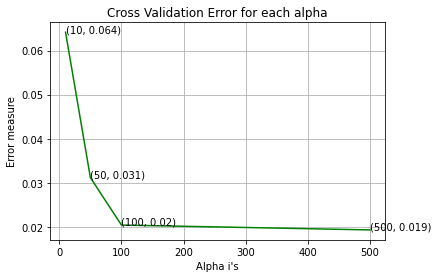

For values of best alpha =  500 The train log loss is: 0.010250953693512739
For values of best alpha =  500 The cross validation log loss is: 0.01931396483675239
For values of best alpha =  500 The test log loss is: 0.02042808981804889


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True,
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1,
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1,
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500]
cv_log_error_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,n_jobs=-1,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],n_jobs=-1,nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


no improvement after adding the entropy